## Multi-label prediction with Planet Amazon dataset

> ## 수고하셨습니다. data를 준비하는 것이 쉽지 않았을텐데, 문제를 잘 해결하셨네요. 
> ## 한 번 이번 exercise를 되돌아보며 data들을 구하고 처리 하는 과정을 한 번 더 생각해보세요.

> ## 추가로 더 공부한 내용들, 궁금한 부분은 notebook에 남겨보세요, issue에 남겨도 좋아요!(제가 바로 확인할 수 있습니다.)
> ## telegram에 공유하면 최고!

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


뒤에 kaggle에서 안받아져서 데이터를 직접 mv로 옮기느라 마운트 했다.

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

cmd에서 실행했다.

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal). For Windows, uncomment the last two commands.

In [5]:
'''from google.colab import files
files.upload()'''

'from google.colab import files\nfiles.upload()'

여기가 제일 골치아팠다. 원래 Kaggle에서 바로 받으려고 했는데, 404 에러가 떠서 결국 직접 다운받아서 업로드하려고 했다. 그런데 그것도 너무 오래걸려서 결국 최종적으로는 구글드라이브에 업로드하고, 그걸 mv해서 unzip하기로 했다...

In [0]:
#! mkdir '/.kaggle/'
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
#! mkdir %userprofile%\.kaggle
#! move kaggle.json %userprofile%\.kaggle

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [8]:
!ls

gdrive	sample_data


In [9]:
! mv '/content/gdrive/My Drive/fastai-v3/train-jpg.tar.7z' '/root/.fastai/data/planet'
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}
! mv '/content/gdrive/My Drive/fastai-v3/train_v2.csv.zip' '/root/.fastai/data/planet'
! unzip -q -n {path}/train_v2.csv.zip -d {path}


mv: cannot stat '/content/gdrive/My Drive/fastai-v3/train-jpg.tar.7z': No such file or directory


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip-full` in your terminal).

In [0]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

앞을 pip로 바꿔서 cmd에서 실행했다.

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [11]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


label이 붙은 모습이다.

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

우리는 사진들에 뒤집기, 뒤틀기, 색조변경 등 다양한 변형을 해줄 것이다. 

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

지금까지와 달리 DataBunch를 만들기 위해 datablock API를 사용한다. path에서 데이터와 csv를 가져오고, 20퍼센트는 valid set으로 쓰일 것이다. 

datablock API를 쓰면 다양한 옵션을 쉽게 적용할 수 있다.

https://docs.fast.ai/data_block.html#The-data-block-API

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

변형과 normalize까지 적용해서 DataBunch를 만들었다.

`show_batch` still works, and show us the different labels separated by `;`.

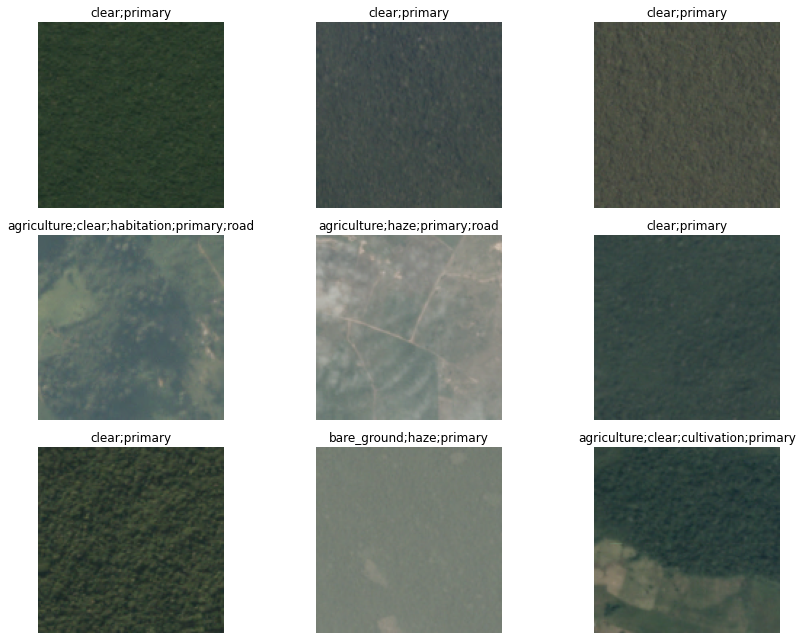

In [15]:
data.show_batch(rows=3, figsize=(12,9))

다음과 같은 이미지를 뽑아보았고, 위쪽 label들이 지금과는 달리 multi label인 것을 볼 수 있다. 이제부터는 지금까지의 exercise들에서 해온 과정을 그대로 반복하면 된다. 

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

resnet50의 model을 가져와서 learner를 만드는데 쓰도록 하겠다.

In [41]:
len(data.classes)

17

In [42]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

17개의 가능한 label들이 있다.

In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


**이부분이 multi label이 붙어있을때와 하나의 label만 붙어있을 때의 가장 큰 차이점이다. 우리는 이전과는 달리 17개의 label에서 단 하나만이 아닌 n개를 목표로 하고 있기 때문에 서로 비교하는 것은 의미가 없다. 그래서 이번엔 threshold를 지정해준다. 그리고 만약에 해당 label일 가능성이 threshold보다 높으면 해당 label 또한 맞다고 판단할 것이다. 즉! 가장 높은 것이 아닌, 기준보다 높은 것들이다.**


익숙한 cnn_learner로 learn에 learner를 지정하고,

> ## 이번 exercise의 핵심이죠! XD

We use the LR Finder to pick a good learning rate.

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


좋은 learning rate를 찾은 뒤,

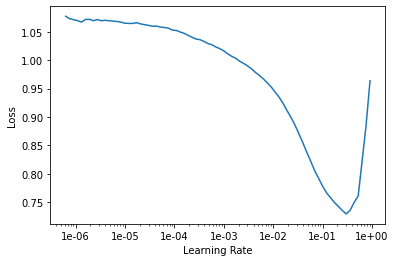

In [19]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135249,0.118107,0.945653,0.895003,02:16
1,0.110236,0.101880,0.953820,0.911304,02:16
2,0.105189,0.091783,0.950666,0.921482,02:16
3,0.097617,0.088116,0.954518,0.924659,02:15
4,0.090641,0.086889,0.955121,0.925667,02:17


training을 해준다. 정확도가 점점 올라간 모습을 볼 수 있다.

In [0]:
learn.save('stage-1-rn50')

구한 값들을 저장해둔다.

...And fine-tune the whole model:

In [0]:
learn.unfreeze()

unfreeze하고,

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


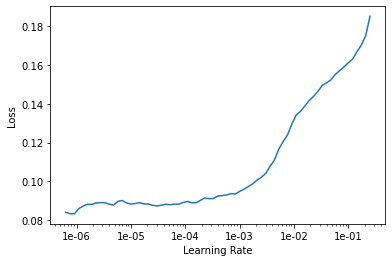

In [24]:
learn.lr_find()
learn.recorder.plot()

마찬가지로 적절한 learning rate를 찾아 보여준다.

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098114,0.091642,0.956930,0.920524,02:22
1,0.095283,0.090535,0.955397,0.922466,02:22
2,0.092051,0.086317,0.958180,0.925153,02:22
3,0.085811,0.083044,0.959002,0.929373,02:21
4,0.080022,0.082255,0.958326,0.929700,02:21


수정된 결과이다.

In [0]:
learn.save('stage-2-rn50')

이번 단계도 저장한다.

In [27]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

이번엔 새로운 DataBunch를 만든다. 여기서부터와 위의 차이점은 size이다(128에서 256으로). 그런데 왜 새로 만드느냐! 계속 반복하면 Overfitting이 일어나기 때문에 general이 아닌 specific한 것만 구분할 수 있기 때문이다. learner는 유지해둬도 되지만, DataBunch는 새로 만들어야만 한다.

In [0]:
learn.freeze()

아까 풀은걸 다시 freeze해주고,

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


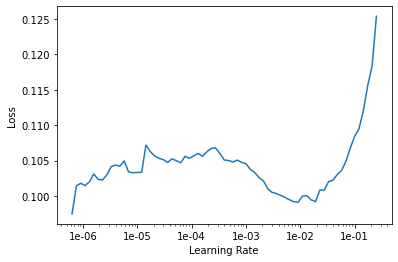

In [29]:
learn.lr_find()
learn.recorder.plot()

좋은 learning rate를 찾아서 fitting 해준다.

In [0]:
lr=1e-2/2

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087635,0.085529,0.959132,0.926972,04:08
1,0.087622,0.084760,0.958217,0.925292,04:10
2,0.086799,0.082765,0.959270,0.929447,04:09
3,0.080892,0.081917,0.959525,0.929902,04:08
4,0.079250,0.081616,0.959648,0.930550,04:06


In [0]:
learn.save('stage-1-256-rn50')

이 단계를 저장해두고,

In [0]:
learn.unfreeze()

learner를 다시 unfreeze해서 model을 수정한다.

In [34]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082255,0.085870,0.958980,0.927580,04:21
1,0.085140,0.086446,0.953021,0.927399,04:21
2,0.083317,0.083438,0.959350,0.928327,04:21
3,0.077283,0.081346,0.959808,0.931011,04:20
4,0.074316,0.080914,0.960186,0.931067,04:22


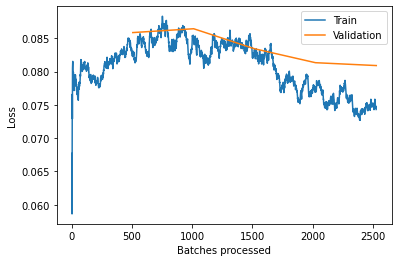

In [35]:
learn.recorder.plot_losses()

이런 결과가 나왔다. validation이 train보다 높으므로 좋다.

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [0]:
learn.export()

우리가 찾은 값들을 추출해서 저장한다!

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [0]:
! mv '/content/gdrive/My Drive/fastai-v3/train-jpg.tar.7z' '/root/.fastai/data/planet'
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}
! mv '/content/gdrive/My Drive/fastai-v3/train_v2.csv.zip' '/root/.fastai/data/planet'
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [39]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

1

In [43]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

IndexError: ignored

**여기 에러가 떴는데 왜그런지 모르겠다... 강의에도 이부분은 다루지 않아서 안나와있다. 일단 여기부터는 뭔가 Kaggle에 결과로 제출하는 내용인거 같다.**

In [44]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

NameError: ignored

In [0]:
labelled_preds[:5]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
#! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

Private Leaderboard score: 0.9296 (around 80th)